In [61]:
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

In [62]:
raw_data_path = os.path.join(os.path.pardir,'data','raw','DataFiles')

ncaa_tourney_compact = os.path.join(raw_data_path, 'NCAATourneyCompactResults.csv')
seas_2018 = os.path.join(os.path.join(os.path.pardir,'data','raw','PrelimData2018'), 'RegularSeasonCompactResults_Prelim2018.csv')

ncaa_tourney_seeds = os.path.join(raw_data_path, 'NCAATourneySeeds.csv')
ncaa_tourney_seeds2018 = os.path.join(os.path.join(os.path.pardir,'data','raw','SampleTourney2018'), 'NCAATourneySeeds_SampleTourney2018.csv')

sample_sub = os.path.join(os.path.pardir,'data','raw','SampleSubmissionStage1.csv')
sample_sub2 = os.path.join(os.path.pardir,'data','raw','SampleSubmissionStage2.csv')
#sample_sub2 = os.path.join(os.path.join(os.path.pardir,'data','raw','SampleTourney2018'), 'SampleSubmissionStage2_SampleTourney2018.csv')


df_tour = pd.read_csv(ncaa_tourney_compact)
#df_tour = pd.read_csv(seas_2018)

#df_seeds = pd.read_csv(ncaa_tourney_seeds)
df_seeds = pd.read_csv(ncaa_tourney_seeds2018)
df_sample_sub = pd.read_csv(sample_sub)
df_sample_sub2 = pd.read_csv(sample_sub2)

In [63]:
#df_tour[~df_tour['WTeamID'].isin(df_seeds['TeamID'])].dropna()
#df_tour[~df_tour['LTeamID'].isin(df_seeds['TeamID'])].dropna()
df_tour.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2112,2017,146,1314,75,1246,73,N,0
2113,2017,146,1376,77,1196,70,N,0
2114,2017,152,1211,77,1376,73,N,0
2115,2017,152,1314,77,1332,76,N,0
2116,2017,154,1314,71,1211,65,N,0


In [64]:
df_seeds.tail()

,Season,Seed,TeamID
2209,2018,Z12,1308
2210,2018,Z13,1149
2211,2018,Z14,1137
2212,2018,Z15,1233
2213,2018,Z16,1335


In [65]:
df_tour.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2112,2017,146,1314,75,1246,73,N,0
2113,2017,146,1376,77,1196,70,N,0
2114,2017,152,1211,77,1376,73,N,0
2115,2017,152,1314,77,1332,76,N,0
2116,2017,154,1314,71,1211,65,N,0


In [66]:
df_sample_sub.tail()

,ID,Pred
9107,2017_1455_1458,0.5
9108,2017_1455_1462,0.5
9109,2017_1457_1458,0.5
9110,2017_1457_1462,0.5
9111,2017_1458_1462,0.5


In [67]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int

df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # 

In [68]:
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
#df_tour2018.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)

In [69]:
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.tail()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
2112,2017,1314,1246,1,2,-1
2113,2017,1376,1196,7,4,3
2114,2017,1211,1376,1,7,-6
2115,2017,1314,1332,1,3,-2
2116,2017,1314,1211,1,1,0


In [70]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.tail()

,SeedDiff,Result
2112,1,0
2113,-3,0
2114,6,0
2115,2,0
2116,0,0


In [71]:
X_train = df_predictions.SeedDiff.values.reshape(-1,1)
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)

In [72]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.553, with best C: 0.01


Text(0,0.5,'P(Team1 will win)')

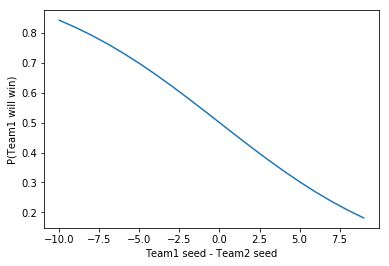

In [73]:
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

In [74]:
n_test_games = len(df_sample_sub2)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

In [75]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub2.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    
    if df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].empty:
        t1_seed = 8
    else:
        t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
        
    if df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].empty:
        t2_seed = 8
    else:
        t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]

    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

In [76]:
print(X_test.shape)
#print(y_test.shape)
print(X_train.shape)
print(y_train.shape)

(2278, 1)
(4234, 1)
(4234,)


In [77]:
preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub2.Pred = clipped_preds
df_sample_sub2.head()

,ID,Pred
0,2018_1104_1112,0.302236
1,2018_1104_1113,0.458264
2,2018_1104_1116,0.417105
3,2018_1104_1120,0.302236
4,2018_1104_1137,0.697764


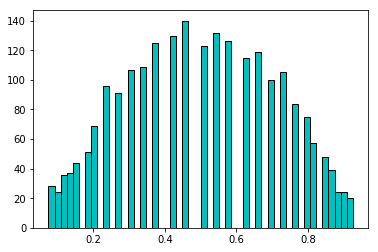

In [78]:
plt.hist(clipped_preds, bins=50, color='c', edgecolor='black');

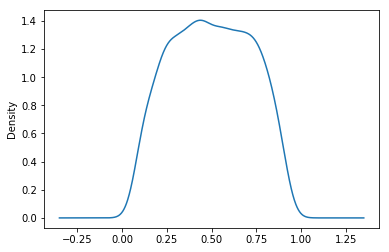

In [79]:
df_sample_sub2.Pred.plot.kde();

In [80]:
teams = os.path.join(raw_data_path, 'Teams.csv')
df_teams = pd.read_csv(teams)

In [81]:
df_results = pd.DataFrame(columns=['WTeam','LTeam','Prob'])

i = 0
for ii, row in df_sample_sub2.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    
    df_results.loc[i] = [df_teams[df_teams.TeamID == t1].TeamName.values[0],df_teams[df_teams.TeamID == t2].TeamName.values[0],row.Pred]
    i=i+1

In [82]:
df_results.to_csv('logreg_seed_starter2.csv', index=False)